# Chapter 10 - Identification and the Causal Algorithm

The notebook is a code companion to chapter 10 of the book [Causal AI](https://www.manning.com/books/causal-ai) by [Robert Osazuwa Ness](https://www.linkedin.com/in/osazuwa/). View the [book resources](https://www.altdeep.ai/causalaibook) to see other tutorials and book-related links.

<a href="https://colab.research.google.com/github/altdeep/causalML/blob/master/book/chapter%2010/Chapter_10_Identification_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Listing 10.1 Creating a query in y0

We work with the online gaming example mentioned in previous chapters, where a player's membership in a guild (G) drives side-quest engagement (E), and side-quest engagement and guild membership drive in-game purchases (I).

![online-gaming-dag](https://github.com/altdeep/causalML/blob/master/book/chapter%2010/images/online-gaming.png?raw=true)

In identification, we work directly with queries. The library y0 in Python gives as a domain specific language for representing queries. Suppose where interested in the question, "How much in-game purchases would a player have if side-quest engagement were high?", i.e., the query $P(I_{E=e})$.

In [16]:
!pip install git+https://github.com/y0-causal-inference/y0.git@v0.2.0
from y0.dsl import P, Variable     #A
E = Variable("E")     #B
I = Variable("I")     #B
query = P[E](I)     #C
query     #D
#A "P" is for probability distributions, and "Variable" is for defining variables.
#B Define variables G (guild membership), E (side-quest engagement), and I (in-game purchases).
#C Define the distributional query P(I_E).
#D If running in a notebook environment, this will show a rendered image of P(I_E)

  Cloning https://github.com/y0-causal-inference/y0.git (to revision v0.2.0) to /tmp/pip-req-build-hryw7s8k
  Running command git clone --filter=blob:none --quiet https://github.com/y0-causal-inference/y0.git /tmp/pip-req-build-hryw7s8k
  Running command git checkout -q e1eae5096ae3ed9f086347e30da08fd5e5e71982
  Resolved https://github.com/y0-causal-inference/y0.git to commit e1eae5096ae3ed9f086347e30da08fd5e5e71982
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


P(I @ -E)

## Listing 10.2 Building the online gaming DAG in y0

Let's build the DAG with y0.

In [ ]:
#Install Graphviz for plotting
!pip install graphviz==0.20.3
!apt install libgraphviz-dev
!pip install pygraphviz==1.13
!pip install networkx==2.8.8

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgraphviz-dev is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Code fetched successfully.
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout, to_agraph
import itertools
from IPython.display import Image
import pygraphviz as pgv

from y0.graph import NxMixedGraph
from y0.dsl import Probability
from y0.identify import is_identifiable

from typing import Tuple

def convert_graph(dag: nx.DiGraph, observational: list) -> Tuple[nx.DiGraph, nx.Graph]:
    """
    This function converts a nx.DiGraph DAG to the mixed graph (ADMG) format
    used by y0.  It removes unobserved nodes from the given DAG.  When B is
    removed from A -> B -> C, it creates a new edge A -> C.  When a common cause
    is removed, such as in A <- B -> C, it adds an undirected edge between A and
    C; these correspond to bidirected

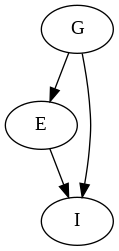

In [17]:
import requests    #A
def download_code(url):    #A
    response = requests.get(url)    #A
    if response.status_code == 200:    #A
        code_content = response.text    #A
        print("Code fetched successfully.")    #A
        return code_content    #A
    else:    #A
        print("Failed to fetch code.")    #A
        return None    #A
url = (
    "https://raw.githubusercontent.com/altdeep/"
    "causalML/master/book/chapter%2010/id_utilities.py"    #A
)
utilities_code = download_code(url)    #A
print(utilities_code)    #B
# After checking, uncomment the exec call to load utilities
#exec(utilities_code)    #B

from y0.graph import NxMixedGraph as Y0Graph    #C
from y0.dsl import P, Variable    #D
G = Variable("G")    #D
E = Variable("E")    #D
I = Variable("I")    #D
dag = Y0Graph.from_edges(    #D
    directed=[    #D
        (G, E),    #D
        (G, I),    #D
        (E, I)    #D
    ]    #D
)    #D
gv_draw(dag)    #E
#A Install graphviz for DAG visualization
#A Download some helper functions for identification and visualization that converts some y0 abstractions into abstractions we're familiar with.
#B Inspect the downloaded code before executing as a matter of good security practice. Then execute.
#C y0 works with custom graph class called NxMixedGraph. To avoid confusion, we'll call it a Y0Graph, and use it to implement DAGs.
#D Build the graph.
#E Draw the graph with a graphviz helper function.

## Listing 10.3 Checking identification of $P(I_{E="high"})$ from P(G, E, I)

Our goal in chapter 7 was to use our model of $P(G, E, I)$ to simulate from $P(I_{E="high"})$ using the intervention operator pyro.do. I did this simulation and provided empirical evidence that it works for this online game example. Identification means showing that it works in general, based on your model and assumptions. Formally, we want to be sure that level 1 distribution P(G, E, I) (or data from that distribution) combined with our DAG, is enough to simulate from level 2 distribution $P(I_{E="high"})$. Identification with y0 confirms that this is indeed possible.

In [18]:
e = E    #A
check_identifiable(    #B
    dag,    #B
    query=P(I @ e),    #B
    distribution=P(G, E, I)    #B
)    #B
#A Make a lower-case "e" to represent an intervention value.
#B Check identifiability given the DAG, a distribution, and a target query. y0 represents ideal interventions with @, we write P(I_{E=e}) as P(I @ e).

True

## Listing 10.4 Checking identification of $P(I_{E="high"})$ from P(E, I)

But what if we didn't have any observations of guild membership G?  We can use y0 to test if we have identification for P(IE="high") from P(E, I) – in other words, if it is possible to infer $P(I_{E="high"})$ from observations of E and I only.

In [19]:
check_identifiable(
    dag,
    query=P(I @ e),
    distribution=P(E, I)
)

False

This returns False, because we don't have identification for $P(I_{E=e})$ from the DAG and P(E, I) given our graphical assumptions.

## Listing 10.5 Deriving the estimand to get $P(I_{E="high"})$ from P(E, I, G)

We passed our DAG and the intervention-level query P(I_{E="high"}) to y0 and it told us it was identifiable from P(E, I, G). Now let's use y0 to derive the estimand, the operation we apply to P(E, I, G) to get P(I_{E="high"}).



In [20]:
from y0.graph import NxMixedGraph as Y0Graph
from y0.dsl import P, Variable
from y0.algorithm.identify import Identification, identify

query=P(I @ e)
base_distribution = P(I, E, G)

identification_task = Identification.from_expression(
    graph=dag,
    query=query,
    estimand=base_distribution)

identify(identification_task)

Sum[G](Sum(Sum[E, I](P(E, G, I))) * P(I | E, G))

## Listing 10.6 Deriving the front door estimand in y0

Graphical identification algorithms automate the application of graph-based identification systems like the do-calculus. When we used y0 to check for identification of $P(I_{E=e})$ and to derive the backdoor estimand, it was using its implementation of graphical identification algorithms. In this section, we'll see how to use these algorithms to identify another useful estimand called the front-door adjustment estimand.

In our online gaming example, suppose you were not able to observe guild membership. Then you would not have backdoor identification of $P(I_{E=e})$. However, suppose we had a mediator between side-quest engagement (E) and In-game purchases (I) – a node on the between E and I. Specifically, our mediator represents won virtual items (W), as seen in the following figure.

![Causal DAG with mediation variable](https://github.com/altdeep/causalML/blob/master/book/chapter%2010/images/online-gaming-mediated.png?raw=true)

The idea of won items is as follows. When a player successfully completes a side-quest, they win a virtual item. The more side-quests they finish, the more items they earn. Those won virtual items and purchased virtual items can complement one another. For example, winning a magic bow motivates purchases of magical arrows. Thus, the amount of won items a player has influences the amount of virtual items they purchase. Given this graph, we can use y0's implementation of graphical identification algorithms to derive the front door estimand.

In [21]:
from y0.graph import NxMixedGraph as Y0Graph
from y0.dsl import P, Variable
G = Variable("G")    #A
E = Variable("E")    #A
I = Variable("I")    #A
W = Variable("W")    #A
e = E    #A
dag = Y0Graph.from_edges(    #A
    directed=[    #A
        (G, E),    #A
        (G, I),    #A
        (E, W),    #A
        (W, I)    #A
    ]    #A
)    #A

query=P(I @ e)    #B
base_distribution = P(I, E, W)    #C

identification_task = Identification.from_expression(    #D
    graph=dag,    #D
    query=query,    #D
    estimand=base_distribution)    #D
identify(identification_task)    #D

#A Build a new graph with the mediator variable.
#B Still the same query, P(I_{E=e}).
#C But now we observe I, E, and W.
#D Finally, we check if the query is identified given the DAG and observational distribution.

Sum[G, W](Sum(Sum[E, I, W](P(E, I, W))) * P(I | E, G, W) * P(W | E, G))

## Listing 10.7 Plot the recommendation DAG

A conventional causal DAG encodes level 2 assumptions. However, there are graphical techniques to reasoning about counterfactuals. Graphical counterfactual inference only works in special cases, but these cases are quite practical. Further, as usual, working with graphs enables us to automate identification with algorithms. To illustrate graphical counterfactual identification, we'll introduce a new case study.
When you open Netflix, you see the Netflix dashboard. On the dashboard, there are several forms of recommended content. Two types of recommended content are "Top Picks For You", which is a personalized selection of shows and movies that Netflix's algorithms predict you will enjoy based on your past view behavior and ratings, and "Because You Watched", which recommends content based on things you watched recently. Your model of this system includes the following variables:

* **T**: A variable for the recommendation policy that selects a subscriber's "Top Picks for You" content. For simplicity, we'll consider policy "+t" and all other policies "-t" meaning "not t".
* **B**: A variable for the recommendation policy that selects a subscriber's "Because You Watched" content. Again, we'll simplify this to a binary variable with policy "+b" and all other policies "-b" as in "not b."
* **V**: The amount of engagement that a subscriber has with the content recommended by the "Top Picks for You" content.
* **W**: The amount of engagement that a subscriber has with the content recommended by the "Because You Watched" content.
* **A**: Attrition, i.e., whether a subscriber eventually leaves Netflix.
* **C**: Subscriber context, i.e., the type of subscriber we are dealing with. Recommendation algorithms always take the profile of the subscriber into account along with the viewership history, so subscriber profile C is a cause of both recommendation policy variables T and B.

In this section, we'll use y0 to analyze this problem at various levels of the hierarchy. We start by visualizing the graph.


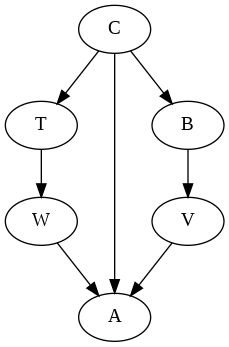

In [22]:
T = Variable("T")    #A
W = Variable("W")    #A
B = Variable("B")    #A
V = Variable("V")    #A
C = Variable("C")    #A
A = Variable("A")    #A
t, a, w, v, b = T, A, W, V, B    #A
dag = Y0Graph.from_edges(directed=[    #B
    (T, W),    #B
    (W, A),    #B
    (B, V),    #B
    (V, A),    #B
    (C, T),    #B
    (C, A),    #B
    (C, B)    #B
])    #B
gv_draw(dag)    #C
#A Define variables for the model.
#B Create the graph.
#C Plot the graph.

## Listing 10.8 Identifying ETT with a graphical identification algorithm

Recall that you get the average treatment effect (ATE) directly (without needing to identify and estimate a level 1 estimand) from a randomized experiment. Suppose you ran such an experiment on a cohort of users and it showed a favorable ATE, for example that +t has a favorable impact on W and A relative to -t. So your team deploys the policy.

Suppose the policy +t works best with users who have watched a lot of movies and thus have more viewing data. For this reason, when the policy is deployed to production, they are more likely to get assigned the policy. But since they are so highly-engaged, they are unlikely to leave regardless of whether they are assigned policy +t or -t. So we could have a situation where the policy +t looks effective in an experiment where people are assigned policies randomly regardless of their level of engagement, but in production assignment is biased to highly-engaged people who are indifferent to the policy.
The counterfactual query that addresses this is a counterfactual version of the ATE called [*effect of treatment on the treated* (ETT, or sometimes ATT)](https://economics.stackexchange.com/questions/45335/what-is-the-difference-between-ate-and-att). We write this as counterfactual query $E(A_{T=+t} – A_{T=-t}|T=+t)$, as in "for people who saw policy +t, how much more attrition do they have relative to what they would have if they had seen -t?". Decomposing for binary A as we did with the ATE, we can write this as $P(A_{T=+t}=+a|T=+t) – P(A_{T=-t}=+a|T=+t)$. $P(A_{T=+t}=+a|T=+t)$ simplifies to P(A=+a|T=+t) by the law of consistency. So we focus on the second term $P(A_{T=-t}=+a|T=+t)$.
In this special case of binary A, we can identify the ETT using graphical identification (for non-binary A, more level 3 assumptions are needed). To do graphical identification for counterfactuals, we can use ID algorithms with counterfactual graphs.
Y0 can derive an estimand for ETT using a graphical identification algorithm IDC*.


In [23]:
from y0.algorithm.identify.idc_star import idc_star

idc_star(
    dag,
    outcomes={A @ -t: +a},    #A
    conditions={T: +t}    #B
)
#A Counterfactual outcome A_{T=-t} = +a
#B Corresponds to the actual outcome T = +t

((Sum[B, C, V, W](P(V @ -B) * P(W @ -T) * P(A @ (-C, -V, -W)) * P(B @ -C) * P(T @ -C) * P(C)) / Sum[A, B, C, V, W](Sum[B, C, V, W](P(V @ -B) * P(W @ -T) * P(A @ (-C, -V, -W)) * P(B @ -C) * P(T @ -C) * P(C)))))

## Listing 10.9 Plotting the parallel world graph with y0

The intuition is that we are applying graphical identification algorithms over something called a counterfactual graph. Up until now, our graph of choice for counterfactual reasoning was the parallel world graph. Indeed, we can have y0 make a parallel world graph for us.

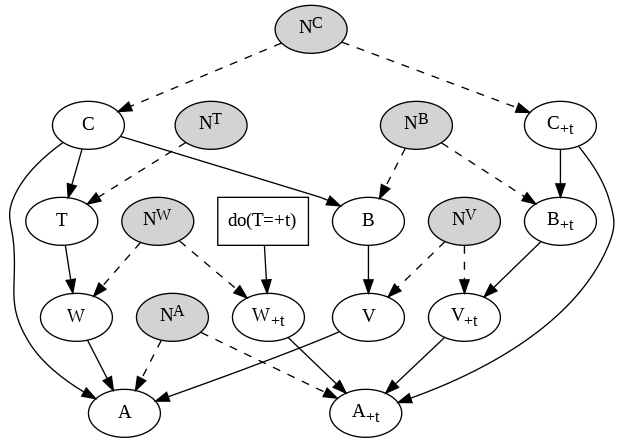

In [24]:
from y0.algorithm.identify.cg import make_parallel_worlds_graph
parallel_world_graph = make_parallel_worlds_graph(    #A
    dag,    #A
     {frozenset([+t])}    #A
)    #A
gv_draw(parallel_world_graph)    #B
#A The make_parallel_worlds_graph method takes an input DAG and sets of interventions. It constructs a new world for each set.
#B The helper function visualizes the graph in a familiar way.

## Listing 10.10 Counterfactual graph events $A_{T=-t}=+a$ and T=+t

This graph differs slightly from the ones I've drawn because the algorithm applies the subscript for an intervention to every node in the world where the intervention occurred; the subscript indexes all the variables in a world. It's up to us to reason that C from one world and C+t from another must have the same outcomes since C+t is not affected by its world's intervention do(T=+t).

Now recall that the problem with the parallel world graph is that d-separation won't work with it. For example, d-separation in the above figure suggests that C and $C_{+t}$ are conditionally independent given their common exogenous parent $N_C$, but we just articulated that C has and $C_{+t}$ must be the same; if C has a value, $C_{+t}$ must have the same value, thus the are perfectly dependent.

We can remedy this with the counterfactual graph. The counterfactual graph is created by using the graph and the counterfactual query to understand which nodes across worlds in the parallel world graph are equivalent, and then collapsing equivalent nodes into one. The resulting graph contains nodes across parallel worlds that are relevant to the events in the query. We can use y0 to create the counterfactual graph for events $A_{T=-t}=+a$ and T=+t.

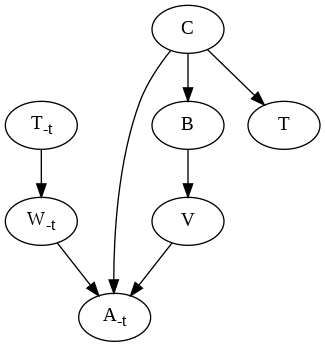

In [25]:
from y0.algorithm.identify.cg import make_counterfactual_graph

events = {A @ -t: +a, T: +t}    #A
cf_graph, _ = make_counterfactual_graph(dag, events)
gv_draw(cf_graph)
#A Counterfactual graphs work with event outcomes in the query. For $P(A_{T=-t}=+a|T=+t)$, we want events $A_{T=-t} =+a$ and T=+t.

## Listing 10.11 Create parallel world graph for do(T=+t) and do(B=-b)

We can also use graphical identification for more advanced queries. For example, suppose you want to isolate how T affects A from how B affects A. You want to focus on users where B was -b. You find the data from a past experiment where "Because you watched…" policy B was randomized. You take that data and zoom in on participants in the experiment who were assigned -b. The outcome of interest in that experiment was V, the amount of engagement with the content recommended in the "Top Picks for You" box. So you have the outcomes of $V_{B=-b}$ for those subscribers of interest. With this new data, you expand your query from $P(A_{T=-t}=+a|T=+t)$ to $P(A_{T=-t}=+a|T=+t, B=-b, V_{B=-b}=v)$, including $V_{B=-b}=v$ because it is helpful in predicting attrition. Now you have three parallel worlds to reason over, the actual, the world with do(T=+t) and the world with do(B=-b).

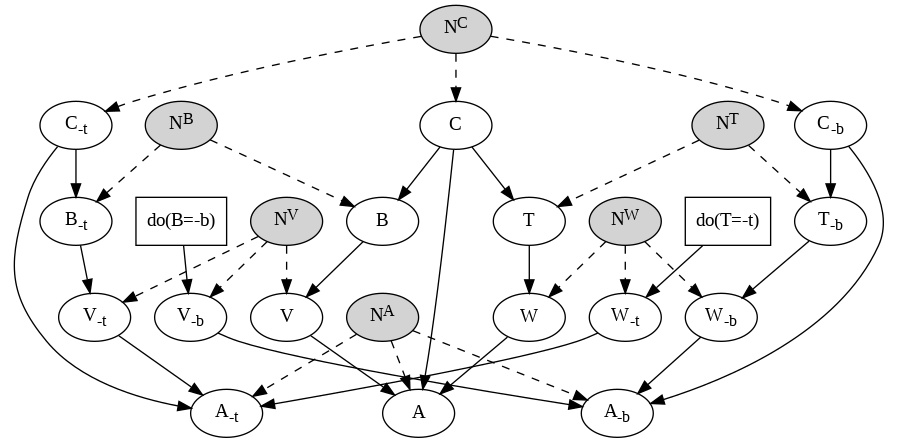

In [26]:
parallel_world_graph = make_parallel_worlds_graph(
    dag,
   {frozenset([-t]), frozenset([-b])}     #A
)
gv_draw(parallel_world_graph)
#A The second argument of make_parallel_worlds_graph enumerates the hypothetical conditions

## Listing 10.12 Counterfactual graph for expanded expression

Notably, the query $P(A_{T=-t}=+a|T=+t, B=-b, V_{B=-b}=v)$ collapses the parallel world graph to the same counterfactual graph as $P(A_{T=-t}=+a|T=+t)$.


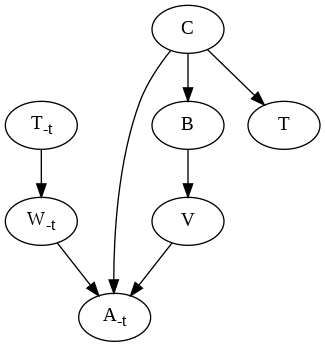

In [27]:
joint_query = {A @ -t: +a, T: +t, B: -b, V @ -b: +v}    #A
cf_graph, _ = make_counterfactual_graph(dag, joint_query)    #A
gv_draw(cf_graph)    #A
#A P(A_{T=-t}=+a|T=+t, B=-b, V_{B=-b}=v) collapses the parallel world graph to the same counterfactual graph as P(A_{T=-t}=+a|T=+t)

## Listing 10.13 Generating from $P(I_{E=0})$ vs $P(I_{E=0}|E=1)$ in Pyro

For simplicity, let's replace E="high" and E="low" with E=1 and E=0 respectively. We know $P(I_{E=0}|E=1)$ is identified given our causal DAG and the single-word assumption. Fortunately, Pyro's (and Chi-Rho's) `do` intervention operator implements the SWIG's node-splitting operation by default (if you used `pyro.render_model` to visualize an intervention and didn't get what you expected, this is why). For ordinary interventional queries on a causal DAG, there is no difference between this and the ordinary graph mutilation approach to interventions. But when we want to condition on E=1 and intervene to set E=0, Pyro will accommodate us. We'll use this approach to sample from $P(I_{E=0}|E=1)$. As a sanity check, we'll also sample from plain vanilla intervention distribution $P(I_{E=0})$ and contrast those samples with samples from $P(I_{E=0}|E=1)$.

As a change in pace, I illustrate using NumPyro instead of Pyro, though the code will work in pyro with only small tweaks. First, let's build the model.


In [28]:
!pip install numpyro==0.15.0
!pip install funsor==0.4.5
import jax.numpy as np
from jax import random
from numpyro import sample
from numpyro.handlers import condition, do
from numpyro.distributions import Bernoulli, Normal
from numpyro.infer import MCMC, NUTS
import matplotlib.pyplot as plt

rng = random.PRNGKey(1)

def model():    #A
    p_member = 0.5
    is_guild_member = sample(    #A
        "Guild Membership",    #A
        Bernoulli(p_member)    #A
    )    #A
    p_engaged = (0.8*is_guild_member + 0.2*(1-is_guild_member))    #A
    is_highly_engaged = sample(    #A
        "Side-quest Engagement",    #A
        Bernoulli(p_engaged)    #A
    )    #A
    p_won_engaged = (.9*is_highly_engaged + .1*(1-is_highly_engaged))    #A
    high_won_items = sample("Won Items", Bernoulli(p_won_engaged))    #A
    mu = (    #A
        37.95*(1-is_guild_member)*(1-high_won_items) +    #A
        54.92*(1-is_guild_member)*high_won_items +    #A
        223.71*(is_guild_member)*(1-high_won_items) +    #A
        125.50*(is_guild_member)*high_won_items    #A
    )    #A
    sigma = (    #A
        23.80*(1-is_guild_member)*(1-high_won_items) +    #A
        4.92*(1-is_guild_member)*high_won_items +    #A
        5.30*(is_guild_member)*(1-high_won_items) +    #A
        53.49*(is_guild_member)*high_won_items    #A
    )    #A
    in_game_purchases = sample("In-game Purchases", Normal(mu, sigma))   #A
#A A version of the online gaming model. The weights are estimates from the data (learning procedure not shown here).

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.7/345.7 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.9/174.9 kB 2.8 MB/s eta 0:00:00


## Listing 10.14 Apply intervention do(E=0) and infer from $P(I_{E=0})$

Next, we apply the intervention and run inference to sample from $P(I_{E=0})$.

In [29]:
intervention_model = do(model, {"Side-quest Engagement": np.array(0.)})    #A
intervention_kernel = NUTS(intervention_model)    #B
intervention_model_sampler = MCMC(    #B
    intervention_kernel,    #B
    num_samples=5000,    #B
    num_warmup=200    #B
)    #B
intervention_model_sampler.run(rng)    #B
intervention_samples = intervention_model_sampler.get_samples()    #B
int_purchases_samples = intervention_samples["In-game Purchases"]    #B
#A Applying the do operator to model
#B Apply inference to sample from P(I_{E=0})

<ipython-input-29-3712d5625c58>:8: FutureWarning: Some algorithms will automatically enumerate the discrete latent site Guild Membership of your model. In the future, enumerated sites need to be marked with `infer={'enumerate': 'parallel'}`.
  intervention_model_sampler.run(rng)    #B
<ipython-input-29-3712d5625c58>:8: FutureWarning: Some algorithms will automatically enumerate the discrete latent site Side-quest Engagement of your model. In the future, enumerated sites need to be marked with `infer={'enumerate': 'parallel'}`.
  intervention_model_sampler.run(rng)    #B
<ipython-input-29-3712d5625c58>:8: FutureWarning: Some algorithms will automatically enumerate the discrete latent site Won Items of your model. In the future, enumerated sites need to be marked with `infer={'enumerate': 'parallel'}`.
  intervention_model_sampler.run(rng)    #B
sample: 100%|██████████| 5200/5200 [00:10<00:00, 494.04it/s, 1 steps of size 5.41e-01. acc. prob=0.61] 


## Listing 10.15 Condition intervention model and infer $P(I_{E=0}|E=1)$

We’ll contrast these samples from $P(I_{E=0})$ with samples we draw from $P(I_{E=0}|E=1)$. To infer $P(I_{E=0}|E=1)$, we'll condition intervention_model on factual condition E=1. Then will run inference again on this conditioned-upon intervened-upon model.

In [30]:
cond_and_int_model = condition(    #A
    intervention_model,    #A
     {"Side-quest Engagement": np.array(1.)}    #A
)    #A
int_cond_kernel = NUTS(cond_and_int_model)    #B
int_cond_model_sampler = MCMC(    #B
    int_cond_kernel,    #B
    num_samples=5000,    #B
    num_warmup=200    #B
)    #B
int_cond_model_sampler.run(rng)    #B
int_cond_samples = int_cond_model_sampler.get_samples()    #B
int_cond_purchases_samples = int_cond_samples["In-game Purchases"]    #B
#A Now apply the condition operator to sample from $P(I_{E=0}|E=1)$
#B Apply inference to sample from $P(I_{E=0}|E=1)$

<ipython-input-30-3d93f6c64a8f>:11: FutureWarning: Some algorithms will automatically enumerate the discrete latent site Guild Membership of your model. In the future, enumerated sites need to be marked with `infer={'enumerate': 'parallel'}`.
  int_cond_model_sampler.run(rng)    #B
<ipython-input-30-3d93f6c64a8f>:11: FutureWarning: Some algorithms will automatically enumerate the discrete latent site Won Items of your model. In the future, enumerated sites need to be marked with `infer={'enumerate': 'parallel'}`.
  int_cond_model_sampler.run(rng)    #B
sample: 100%|██████████| 5200/5200 [00:10<00:00, 509.99it/s, 5 steps of size 8.17e-01. acc. prob=0.21] 


Note that pyro's do and condition subroutines mutually compose; i.e., for a model with a variable X, `do(condition(model, {"X": 1.}), {"X": 0.})` is equivalent to `condition(do(model, {"X": 0.}), {"X": 1.})`.

## Listing 10.16 Plot samples from $P(I_{E=0})$ and $P(I_{E=0}|E=1)$

Finally, we plot samples from $P(I_{E=0})$ and $P(I_{E=0}|E=1)$ and evaluate the difference in these distributions.

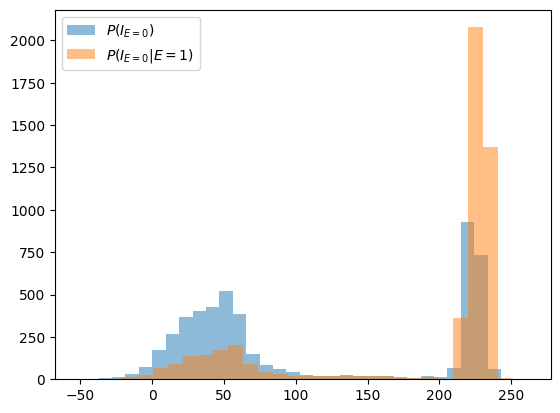

In [31]:
plt.hist(    #A
    int_purchases_samples,    #A
    bins=30,    #A
    alpha=0.5,    #A
    label='$P(I_{E=0})$'    #A
)    #A
plt.hist(    #A
    int_cond_purchases_samples,    #A
    bins=30,    #A
    alpha=0.5,    #A
    label='$P(I_{E=0}|E=1)$'    #A
)    #A
plt.legend(loc='upper left')    #A
plt.show()    #A
#A Plot a histogram of samples from $P(I_{E=0})$
#B Plot a histogram of samples from $P(I_{E=0}|E=1)$